## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)




# Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.3


# Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [2]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [3]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [6]:
tweets, labels = get_tweet(train)

In [7]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

# Tokenizer

1. Tokenizing the tweets

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [11]:
tweets[0]

'i didnt feel humiliated'

# Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

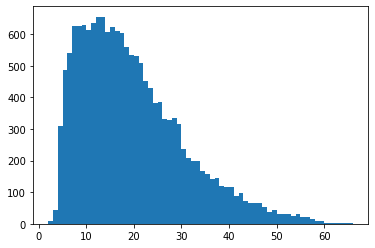

In [12]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [13]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [16]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

# Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes = set(labels)
print(classes)

{'love', 'surprise', 'sadness', 'fear', 'anger', 'joy'}


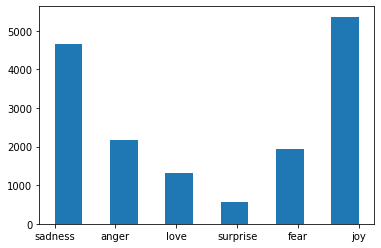

In [18]:
plt.hist(labels, bins = 11)
plt.show()

In [19]:
classes_to_index  = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in classes_to_index.items())

In [20]:
classes_to_index

{'love': 0, 'surprise': 1, 'sadness': 2, 'fear': 3, 'anger': 4, 'joy': 5}

In [21]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [22]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


In [23]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'sadness', 3: 'fear', 4: 'anger', 5: 'joy'}

# Creating the Model

1. Creating the model
2. Compiling the model

In [24]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000,16, input_length= maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# Training the Model

1. Preparing a validation set
2. Training the model

In [26]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)


In [27]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [28]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience= 2)
    ]

)

Epoch 1/20
500/500 [==============================] - 26s 38ms/step - loss: 1.3175 - accuracy: 0.4762 - val_loss: 0.8293 - val_accuracy: 0.6950
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.5352 - accuracy: 0.8134 - val_loss: 0.5089 - val_accuracy: 0.8280
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2764 - accuracy: 0.9103 - val_loss: 0.4313 - val_accuracy: 0.8695
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.1742 - accuracy: 0.9453 - val_loss: 0.4373 - val_accuracy: 0.8765
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.1220 - accuracy: 0.9625 - val_loss: 0.4278 - val_accuracy: 0.8800
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0998 - accuracy: 0.9697 - val_loss: 0.4007 - val_accuracy: 0.8790
Epoch 7/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0841 - accuracy: 0.9746 - val_loss: 0.4856 - val_accuracy:

# Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

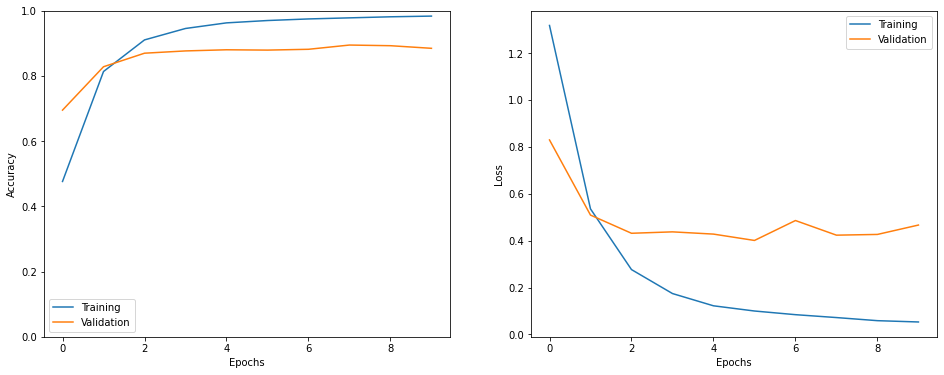

In [29]:
show_history(h)

In [30]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [31]:
mo = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4834 - accuracy: 0.8740


In [32]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i feel so fearless in these post grieving days
Emotion: joy
Predicted Emotion: joy


In [33]:
preds = model.predict(test_seq) 
classes_x=np.argmax(preds,axis=1)

In [34]:
classes_x.shape

(2000,)

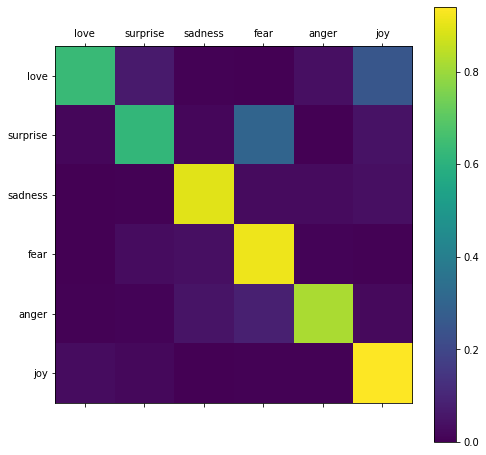

In [35]:
show_confusion_matrix(test_labels, classes_x, list(classes))